[Home](Home.ipynb)

# Coding Through Storytelling

Contrary to what some may believe, programmers are not taught to discourage their imaginations, as if the ability to fantisize were a professional liability.  

Actually, what anchors programming to the real world are what we call "use cases" and these are stories we think through and glean from.  

Even before we start a coding project, we imagine the real world circumstances in which our work is put to some use.  "How will this app make someone's life better?" is not a question to ask too late in the process.

We may also invent short stories to help anchor our understanding of source code.  We need to see the forest, the design pattern, without letting the trees (individual examples) dominate the foreground.  For example, below are our example Supermarket, Shopper and Inventory classes.  

What stories might we weave through here?

Here's one:

A shopper wanders through a supermarket, pushing a shopping cart, and removing items from the shelves.  The shopper comes in with an electronic wallet, a wifi device, such that pulling an item from the shelf completes a transaction.  If the wallet has become empty or has insufficient funds, just put the item back on the shelf, while making no change to the wallet total.  The shopper may still have enough left in the budget for something else.

In eyeballing the code, we find the logic of try / except / else / finally corresponds to the story.  We may choose to add more detail.  We may express our story in the form of a simulation, or workout, or rehearsal, of the script.

In [1]:
# %load shopping_v4.py
"""
Created on Fri Sep 30 10:10:41 2016

@author: Kirby Urner

Show some types working together to simulate a shopper
in a Supermarket, with a fixed starting amount of money.

Inventory keeps track of how much of a product remains.

Supermarket keeps track of income, should equal sum of purchases.
"""

import json

class NoMoney(Exception):
    pass

class OutOfStock(Exception):
    pass

class SuperMarket:
    """
    Persists buyable items in a json file.
    Initializes with 0 cash
    """
    def __init__(self, source):
        self.source = source
    
    def __enter__(self):
        self.inventory = Inventory(self.source)
        self.cash = 0
        return self
        
    def buy(self, shopper, item, how_many):
        """
        remove money from shopper wallet, add qty of item
        to basket, abort if customer short on cash
        """
        if item in self.inventory.wares: # check keys
            price = self.inventory.wares[item][0]
            try:
                self.inventory.remove_item(item, how_many)
                shopper.add_item(item, price, how_many)
                self.cash += price * how_many
            except NoMoney:
                # print("Customer out of money")
                raise  # re-raise exception
            except OutOfStock:
                # print("Don't have enough in stock")
                raise

    def __exit__(self, *oops):
        """
        write json file
        """
        self.inventory.save_items()
        
    def __repr__(self):
        return "SuperMarket with cash: {}".format(self.cash)
          
class Shopper:
    
    def __init__(self, name, budget):
        # self.pronoun = ""
        self.name = name
        self.basket = { }
        self.wallet = budget # budgeted allowance

    def add_item(self, item, price, qty):
        """
        add qty of item to basket and pay, if money available
        """
        if self.wallet - qty * price < 0:
            raise NoMoney
        self.basket[item] = self.basket.get(item, 0) + qty
        self.wallet -= qty * price
        
    def __repr__(self):
        return "{}: {}; {}".format(self.name, self.wallet, self.basket)
        
class Inventory:
    """
    Supermarket brings inventory instance on board upon
    initialization, increments / decrements items, reads
    and writes to json file.  Does not track cash.
    """
    
    def __init__(self, the_file):
        print("Loading inventory...")
        self.storage = the_file
        with open(the_file, 'r') as warehouse:
            self.wares = json.load(warehouse)
            
    def save_items(self):    
        print("Saving inventory...")
        with open(self.storage, 'w') as warehouse:
            json.dump(self.wares, warehouse)
            
    def remove_item(self, item, qty):
        if qty > self.wares[item][1]:
            raise OutOfStock
        self.wares[item][1] -= qty
        
    def add_item(self, item, qty):
        self.wares[item][1] += qty

def test_data():
    stuff = {
       "Snicker-Snacks": [5.99, 10],
       "Polly's Peanuts": [3.99, 10],
       "Dr. Soap": [4.99, 10]}
    with open("the_stuff.json", 'w') as warehouse:  
        json.dump(stuff, warehouse, indent=4)
            
def simulation():
    
    test_data()  # initialize the_stuff.json
    kirby = Shopper("Kirby", 1000)
    
    with SuperMarket("the_stuff.json") as market:
        try:
            market.buy(kirby, "Snicker-Snacks", 2)
            market.buy(kirby, "Polly's Peanuts", 2)
            market.buy(kirby, "Dr. Soap", 2)  # triggers exception
        except NoMoney:
            print("Uh oh, out of money!")
        except OutOfStock:
            print("Uh oh, out of stock!")
        else:
            print(kirby)
            print(market.inventory.wares)
            print(market)
        finally:
            pass

if __name__ == "__main__":
    simulation()

Loading inventory...
Kirby: 970.06; {'Snicker-Snacks': 2, "Polly's Peanuts": 2, 'Dr. Soap': 2}
{'Snicker-Snacks': [5.99, 8], "Polly's Peanuts": [3.99, 8], 'Dr. Soap': [4.99, 8]}
SuperMarket with cash: 29.94
Saving inventory...


For more context, check out [Supermarket Math](https://wikieducator.org/Supermarket_Math) at the Digital Math hub.

In [2]:
from IPython.display import YouTubeVideo

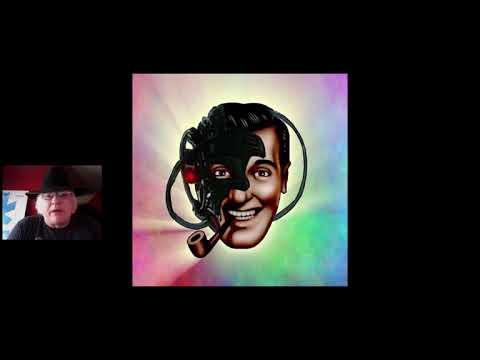

In [3]:
YouTubeVideo("OMMdm4j3KZM")

Another story goes with our Secretary and BusyOfficeWorker pattern, used to introduce ```__set__``` and ```__get__``` methods.

The Secretary type need only be assigned to (self.sec = "message") or retrieved from (messages = self.sec) where sec appears in multiple selves, as a class-level variable.

In [4]:
# %load busyoffice.py
#!/usr/bin/env python3
"""
Created on Tue Dec  5 14:30:35 2017
Modified April 5, 2018
Modified May 24, 2018
Modified June 5, 2021

@author: Kirby Urner

alice = Secretary("Alice")  # implements Descriptor protocol

(data descriptor = full service)

The idea being, self.secretary knows the self that 
calls it, the self.worker, and so can save the 
message directly in self.worker.__dict__['inbox']

Think of other secretaries for other tasks besides
taking taking messages.
"""

import datetime, pytz

UTC = pytz.timezone('UTC')
PACIFIC = pytz.timezone('US/Pacific')
EASTERN = pytz.timezone('US/Eastern')

class Secretary:

    """
    descr.__get__(self, obj, type=None) --> value

    descr.__set__(self, obj, value) --> None

    descr.__delete__(self, obj) --> None
    
    'inbox' is hard-coded as one of the api elements of an obj
    """
    
    def __init__(self, nm):
        self.name = nm
        
    def __set__(self, obj, val):
        print(f"Secretary {self.name}: thank you.  Saving.")
        if not 'inbox' in obj.__dict__:
            obj.inbox = [ ] # initialize empty list
        # (datetime, message) appended to list
        obj.inbox.append((datetime.datetime.now(tz=UTC), val))

    def __get__(self, obj, cls):
        print(f"Worker {obj.worker} {cls.company}: Inbox:")  # obj is the worker's self, cls its class
        if ('inbox' not in obj.__dict__) or ({} == obj.__dict__):
            return 'Empty'
        else:
            return [(message[0].astimezone(tz=obj.timezone), message[1])
                       for message in obj.inbox]
        
class BusyOfficeWorker:

    my_assistant = Secretary("Frank")  # add a layer of politeness
    company = "Global Data Corporation"

    def __init__(self, worker_bee, tz=PACIFIC):
        self.worker = worker_bee
        self.timezone = tz

    def leave_message(self, message):
        self.my_assistant = message  # triggers __set__

    def pickup_message(self):
        return self.my_assistant # that'll be *my* inbox, triggers __get__

    def empty_inbox(self):
        # simplest possible
        if "inbox" in self.__dict__: # if there
            del self.__dict__["inbox"]
            
    def report(self):
        ms = self.pickup_message()
        if ms == 'Empty':
            print('Empty')
        else:
            for m in ms:
                print(f"Time: {m[0]}\n Message: {m[1]}")

def simulation():
    # incoming pipeline
    print("Taking messages...\n")
    worker1 = BusyOfficeWorker("Cindy", PACIFIC)
    worker2 = BusyOfficeWorker("Shelly", EASTERN)

    worker2.report() # testing empty inbox situation

    worker1.leave_message("Hello, this is to remind you...")
    worker2.leave_message("Your dentist appointment for...")
    worker2.leave_message("Your car is ready for pickup.")
    worker1.leave_message("Hello, this is to remind you...")
    worker1.leave_message("Spam call")

    # retrieval process
    print("\nRetrieving messages...\n")
    print("worker1:") 
    worker1.report()

    print()
    print("worker2:")
    worker2.report()
    
if __name__ == "__main__":
    simulation()

Taking messages...

Worker Shelly Global Data Corporation: Inbox:
Empty
Secretary Frank: thank you.  Saving.
Secretary Frank: thank you.  Saving.
Secretary Frank: thank you.  Saving.
Secretary Frank: thank you.  Saving.
Secretary Frank: thank you.  Saving.

Retrieving messages...

worker1:
Worker Cindy Global Data Corporation: Inbox:
Time: 2022-06-30 13:58:16.603982-07:00
 Message: Hello, this is to remind you...
Time: 2022-06-30 13:58:16.604270-07:00
 Message: Hello, this is to remind you...
Time: 2022-06-30 13:58:16.604353-07:00
 Message: Spam call

worker2:
Worker Shelly Global Data Corporation: Inbox:
Time: 2022-06-30 16:58:16.604056-04:00
 Message: Your dentist appointment for...
Time: 2022-06-30 16:58:16.604138-04:00
 Message: Your car is ready for pickup.


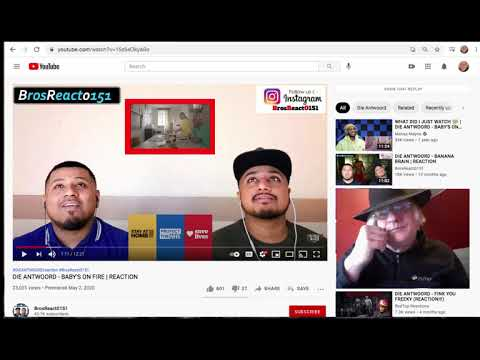

In [5]:
YouTubeVideo("g0RTmVSCsiI")